In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
import glob
import numpy as np
plt.rcParams["figure.figsize"] = [10, 10]

In [4]:
#import 311 data in 311/
threeoneone_df=[]
for filename in glob.iglob('311/311_trim.csv'):
    print filename
    threeoneone_df.append(pd.read_csv(filename))

311/311_trim.csv


/home/fhorta/anaconda3/envs/bigdata/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
threeoneone_df[0].sample(1)

,Unnamed: 0,Created Date,Closed Date,Complaint Type,Incident Zip,Borough
10497592,10497592,06/26/2010 02:35:59 PM,07/01/2010 03:27:16 PM,Broken Muni Meter,10002,MANHATTAN


In [30]:
df = gpd.GeoDataFrame(threeoneone_df[0])

In [6]:
zipdf = gpd.GeoDataFrame.from_file('311/ZIP_CODE_040114.shp', driver='ESRI Shapefile')

In [7]:
ctypes = list(df['Complaint Type'].unique())

In [8]:
groups = df.groupby('Incident Zip')
for i,z in zipdf.iterrows():
    try:
        cs = groups.get_group(z['ZIPCODE'])
        count = len(cs)
        zipdf.set_value(i,'count',count)
        for ct in ctypes:
            count = len(cs[cs['Complaint Type']==ct])
            zipdf.set_value(i,ct,count)
    except:
        pass

In [ ]:
import traceback
for ct in ctypes:
    fig = plt.figure()
    fig.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    vmin=0
    vmax = max(zipdf[ct])
    plt.title(ct)
    if vmax<=1:
        continue
    z = zipdf.plot(ax=ax, column=ct, colormap='Blues', vmin=vmin, vmax=vmax )
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=vmax))
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="3%")
    sm._A = []
    plt.colorbar(sm, cax=cax)
    plt.tight_layout()
    plt.savefig('results/%s.png' % ct.lower().replace('/','_').replace(' ', '-'))

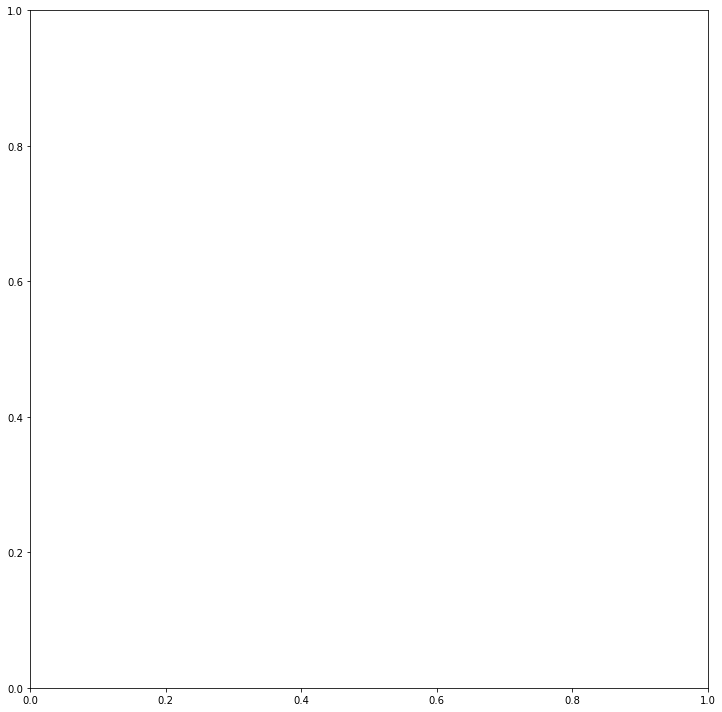

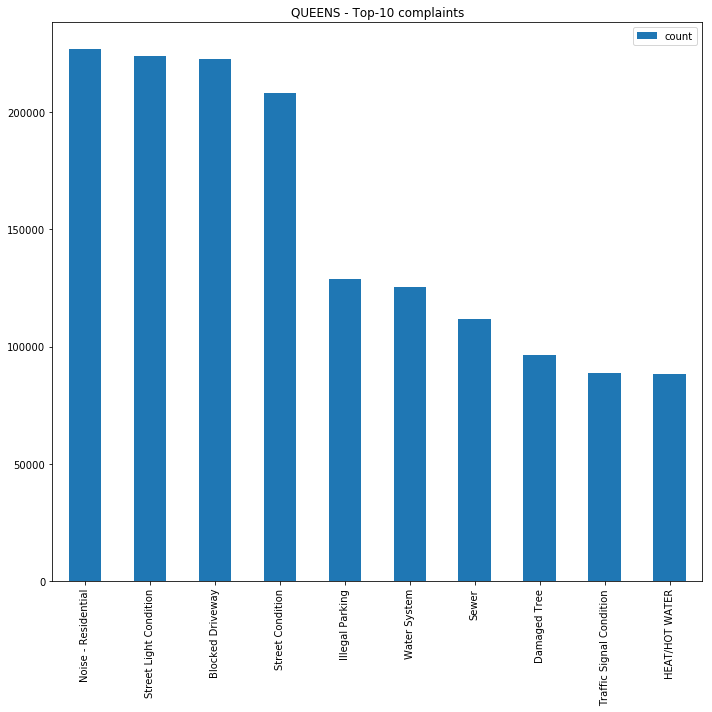

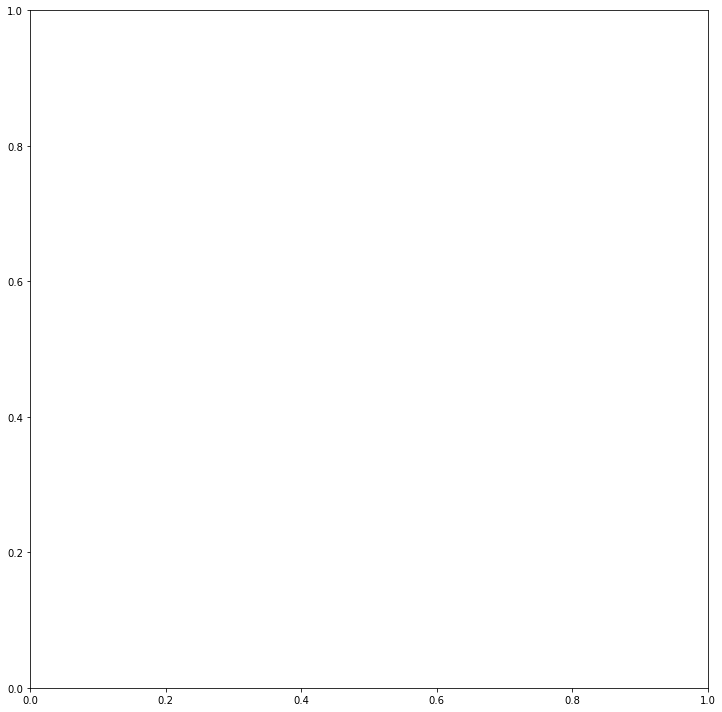

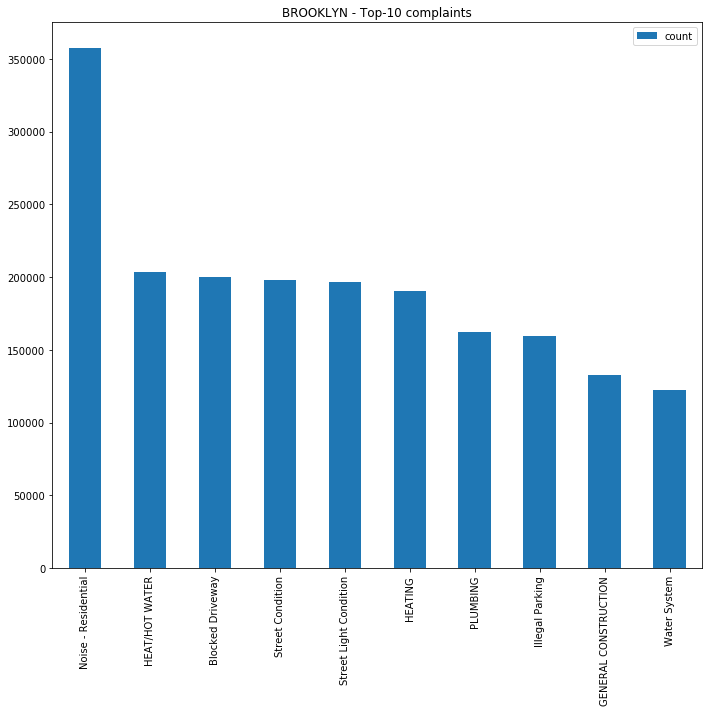

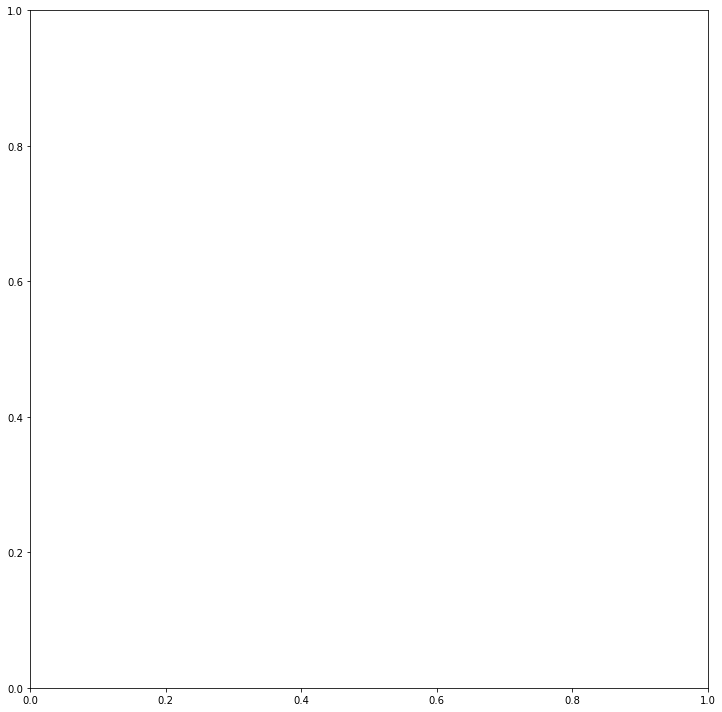

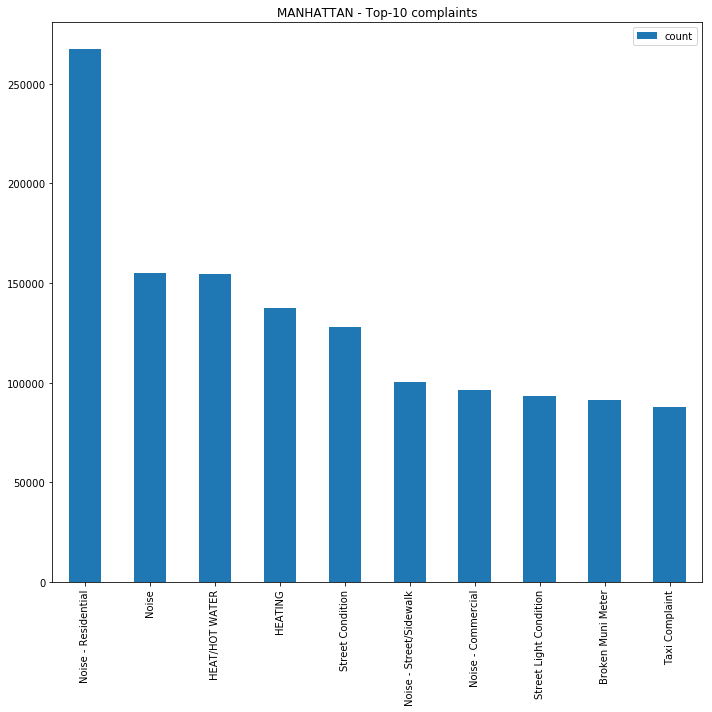

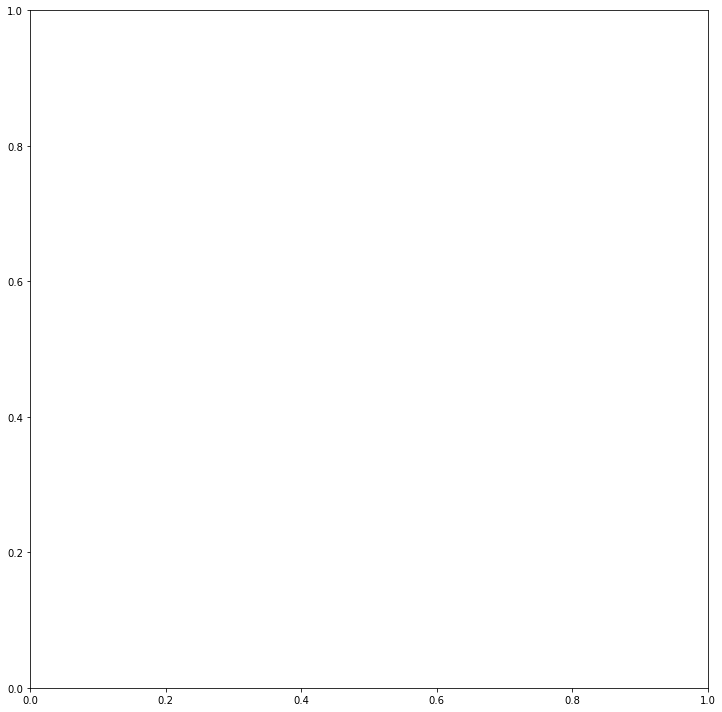

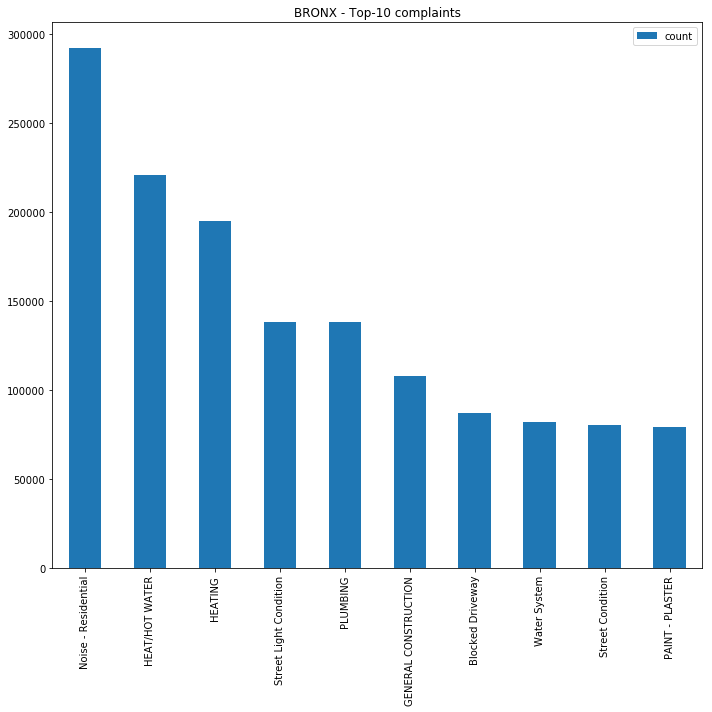

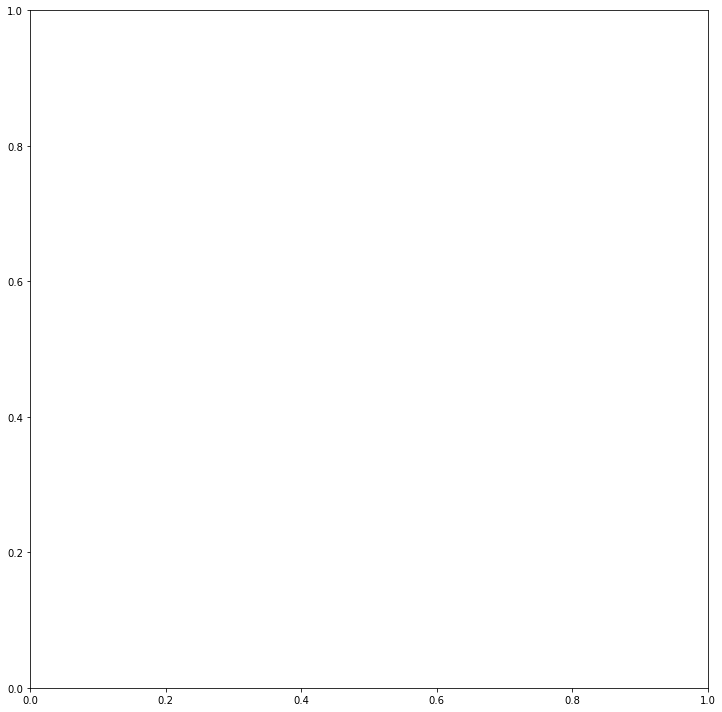

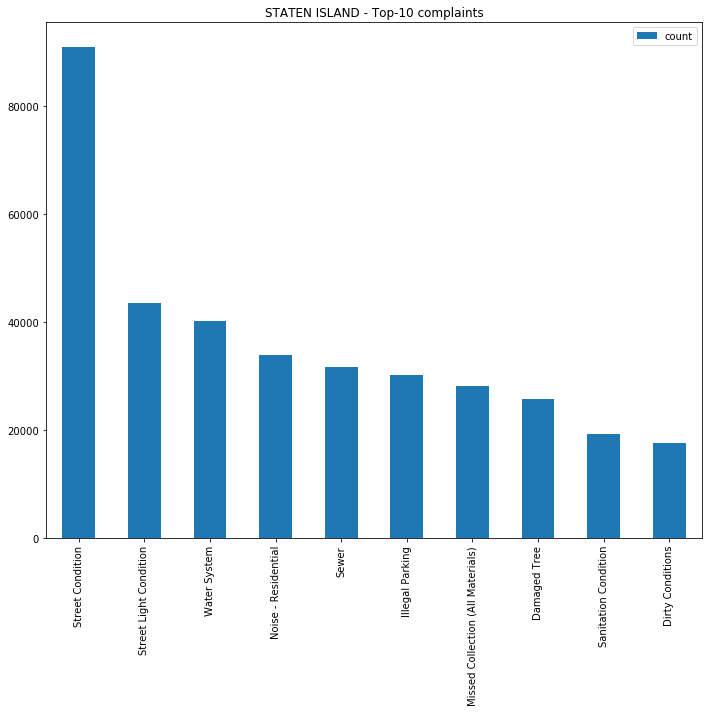

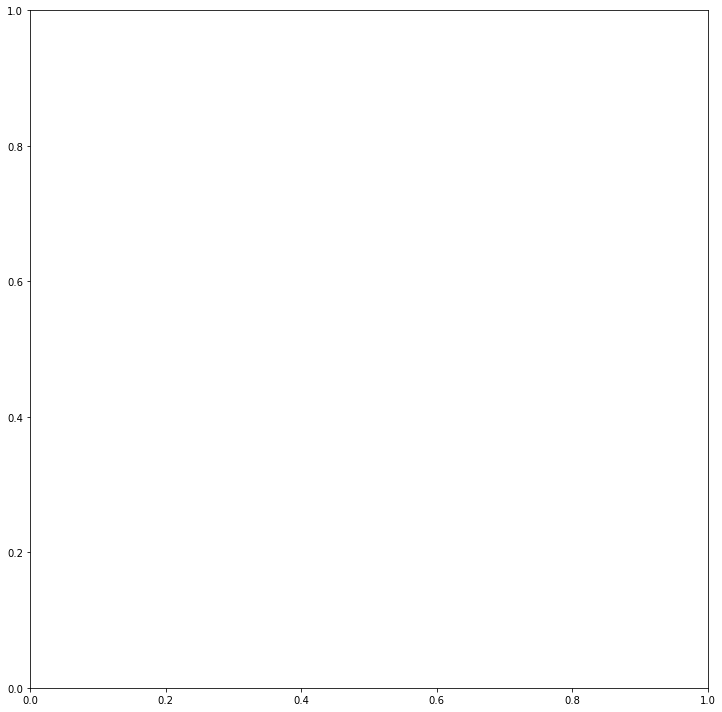

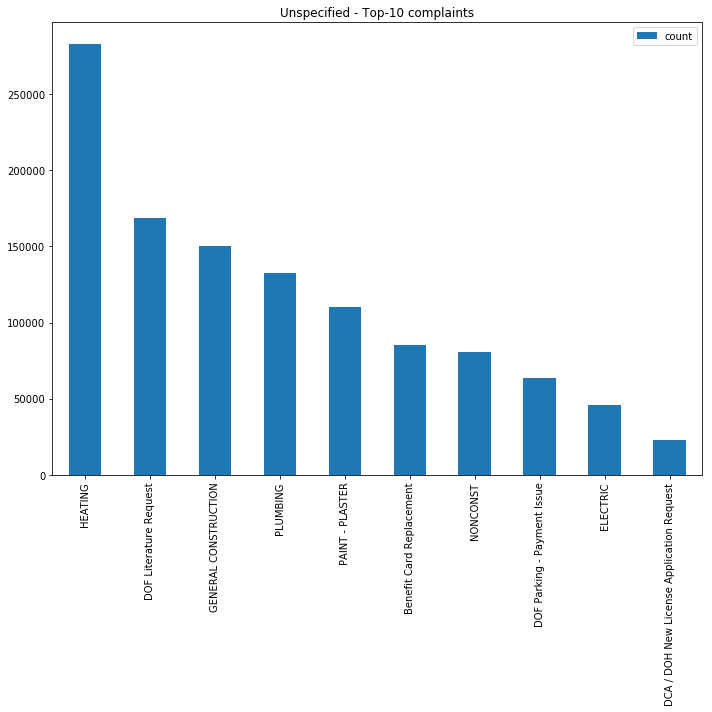

In [70]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

btypes = list(threeoneone_df[0]['Borough'].unique())
bgroups = threeoneone_df[0].groupby('Borough')
for bt in btypes:
    fig = plt.figure()
    fig.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ndf = []
    bg = bgroups.get_group(bt)
    cgroups = bg.groupby('Complaint Type')
    for ct in ctypes:
        try:
            s = len(cgroups.get_group(ct))
        except:
            continue
        if s<=1:
            continue
        ndf.append( { 'type':ct,   'count': s } )

    ndf = pd.DataFrame(ndf)
    ndf = ndf.sort_values(by='count', ascending=0)
    title = '%s - Top-10 complaints' % bt
    plt.gcf().subplots_adjust(bottom=0.5)
    ax = ndf[:10].plot.bar('type', title=title)
    ax.set_xlabel('')
    plt.savefig('results/2-%s-top10-complaints.png' % bt)

In [57]:
from shapely.geometry import Point

g = threeoneone_df[0]

def foo(x):
    return Point(x['Longitude'], x['Latitude'])
    
g['geometry'] = g.apply(foo, axis=1)

KeyError: ('Longitude', u'occurred at index 0')

In [ ]:
g.sample(1000).plot()